In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir = '/mnt/share/costeffectiveness/results/vivarium_ciff_sam/v7.0.0_full_model_no_x_factor/ciff_sam/2022_03_04_17_34_48/count_data/'

In [3]:
figname = 'model_7.0.0'

In [4]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'diarrhea_transition_count.csv',
 'wasting_transition_count.csv',
 'diarrhea_state_person_time.hdf',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'diarrhea_state_person_time.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'diarrhea_transition_count.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [5]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
transitions = pd.read_csv(output_dir + 'disease_transition_count.csv')
deaths = pd.read_csv(output_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,diarrheal_diseases,death,29,baseline,1.0,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases,death,29,baseline,0.0,mild_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases,death,29,baseline,0.0,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,diarrheal_diseases,death,29,baseline,1.0,severe_acute_malnutrition,early_neonatal
4,4,female,2022,diarrheal_diseases,death,29,baseline,3.0,susceptible_to_child_wasting,late_neonatal


In [6]:
state_pt

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.045175,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.006845,mild_child_wasting,early_neonatal
2,2,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.001369,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.000000,severe_acute_malnutrition,early_neonatal
4,4,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.458590,susceptible_to_child_wasting,late_neonatal
...,...,...,...,...,...,...,...,...,...,...
63355,63355,male,2026,susceptible_to_measles,state_person_time,946,zinc_supplementation,191.077344,severe_acute_malnutrition,12_to_23_months
63356,63356,male,2026,susceptible_to_measles,state_person_time,946,zinc_supplementation,23452.451745,susceptible_to_child_wasting,2_to_4
63357,63357,male,2026,susceptible_to_measles,state_person_time,946,zinc_supplementation,6684.265572,mild_child_wasting,2_to_4
63358,63358,male,2026,susceptible_to_measles,state_person_time,946,zinc_supplementation,1577.440110,moderate_acute_malnutrition,2_to_4


In [7]:
groupby_cols = ['input_draw','wasting_state']

In [8]:
def calculate_transition_rates(groupby_cols):
    trans = transitions.loc[transitions.scenario=='baseline']
    trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
    trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')
    trans = trans.groupby(groupby_cols+['cause','measure']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    trans = (trans / pt)[['value']]
    trans = trans#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
    return trans

In [9]:
def calculate_incidence_rrs(strata_cols):
    t = calculate_transition_rates(strata_cols + ['input_draw','wasting_state']).reset_index()
    t = t.loc[t.measure=='incidence']
    tmrel = t.loc[t.wasting_state=='susceptible_to_child_wasting'].set_index(strata_cols + ['input_draw','cause'])[['value']]
    t = t.set_index(strata_cols + ['input_draw','cause','wasting_state'])[['value']] / tmrel
    t = t.groupby(strata_cols + ['cause','wasting_state']).describe(percentiles=[0.025,0.975])
    return t

In [10]:
calculate_incidence_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
lower_respiratory_infections mild_child_wasting            11.0  1.859775   
                             moderate_acute_malnutrition   11.0  4.376520   
                             severe_acute_malnutrition     11.0  8.443443   
                             susceptible_to_child_wasting  11.0  1.000000   
measles                      mild_child_wasting            11.0  1.102253   
                             moderate_acute_malnutrition   11.0  2.668766   
                             severe_acute_malnutrition     11.0  9.084970   
                             susceptible_to_child_wasting  11.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
lower_respiratory_infections mild_child_wasting            0.304124  1.366923   
                             moderate_acute_malnutrition   0.690415  3.169561   
                             severe_acute_malnutrition     1.797017  6.101998   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.205905  0.838163   
                             moderate_acute_malnutrition   0.547180  1.653543   
                             severe_acute_malnutrition     2.356851  5.313262   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                               2.5%       50%   
cause                        wasting_state                                      
lower_respiratory_infections mild_child_wasting            1.410684  1.770106   
                             moderate_acute_malnutrition   3.229916  4.352497   
                             severe_acute_malnutrition     6.122882  8.810986   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.857412  1.119614   
                             moderate_acute_malnutrition   1.686926  2.760765   
                             severe_acute_malnutrition     5.606939  9.007976   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                      \
                                                               97.5%   
cause                        wasting_state                             
lower_respiratory_infections mild_child_wasting             2.411049   
                             moderate_acute_malnutrition    5.436935   
                             severe_acute_malnutrition     11.383002   
                             susceptible_to_child_wasting   1.000000   
measles                      mild_child_wasting             1.393569   
                             moderate_acute_malnutrition    3.395038   
                             severe_acute_malnutrition     13.037452   
                             susceptible_to_child_wasting   1.000000   

                                                                      
                                                                 max  
cause                        wasting_state                            
lower_respiratory_infections mild_child_wasting             2.476578  
                             moderate_acute_malnutrition    5.607312  
                             severe_acute_malnutrition     11.801509  
                             susceptible_to_child_wasting   1.000000  
measles                      mild_child_wasting             1.416120  
                             moderate_acute_malnutrition    3.449

In [11]:
incidence_rrs = calculate_incidence_rrs(['age','sex'])
incidence_rrs

value  \
                                                                               count   
age           sex    cause                        wasting_state                        
1-5_months    female lower_respiratory_infections mild_child_wasting            11.0   
                                                  moderate_acute_malnutrition   11.0   
                                                  severe_acute_malnutrition     11.0   
                                                  susceptible_to_child_wasting  11.0   
                     measles                      mild_child_wasting            11.0   
...                                                                              ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  11.0   
                     measles                      mild_child_wasting             0.0   
                                                  moderate_acute_malnutrition    0.0   
                                                  severe_acute_malnutrition      0.0   
                                                  susceptible_to_child_wasting   0.0   

                                                                                          \
                                                                                    mean   
age           sex    cause                        wasting_state                            
1-5_months    female lower_respiratory_infections mild_child_wasting            1.012284   
                                                  moderate_acute_malnutrition   1.006391   
                                                  severe_acute_malnutrition     1.042675   
                                                  susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting            0.953066   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     std   
age           sex    cause                        wasting_state                            
1-5_months    female lower_respiratory_infections mild_child_wasting            0.061809   
                                                  moderate_acute_malnutrition   0.065748   
                                                  severe_acute_malnutrition     0.194254   
                                                  susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting            0.118385   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     min   
age           sex    cause                        wasting_state                     

In [12]:
# artifact
from vivarium import Artifact
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2020', f'age_end <= 5'])

In [13]:
wasting_rrs = art.load('risk_factor.child_wasting.relative_risk')

In [14]:
wasting_rrs = (art.load('risk_factor.child_wasting.relative_risk')
               .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
               .reset_index())
wasting_rrs['age'] = np.where(wasting_rrs['age_start'] == 0, 'early_neonatal', #1
                                            np.where(wasting_rrs['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(wasting_rrs['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(wasting_rrs['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(wasting_rrs['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2

wasting_rrs.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,count,mean,std,min,2.5%,50%,97.5%,max,age
0,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
1,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat2,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
2,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat3,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
3,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat4,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
4,Female,0.0,0.019178,2020,2021,lower_respiratory_infections,incidence_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal


In [15]:
def plot_incidence_relative_risks(age, sex, cause, measure):
    width=0.4
    if measure == 'incidence_rate':
        s = incidence_rrs.reset_index()
    elif measure == 'CSMR':
        s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

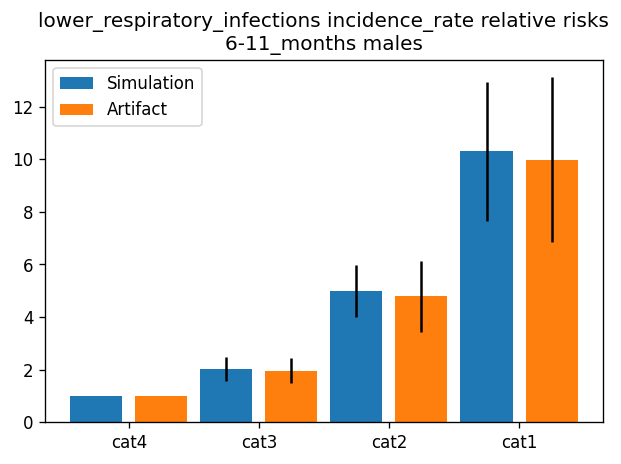

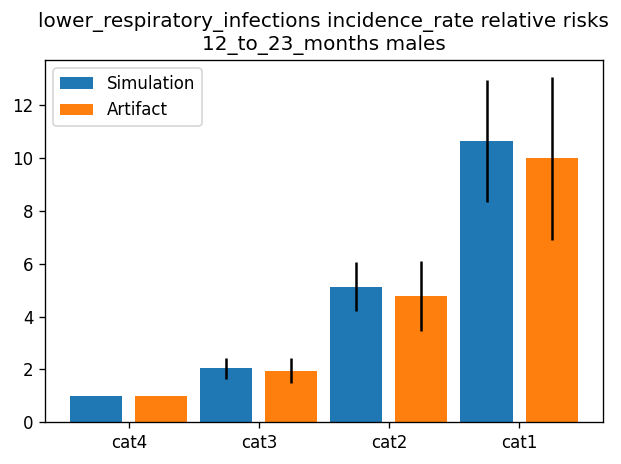

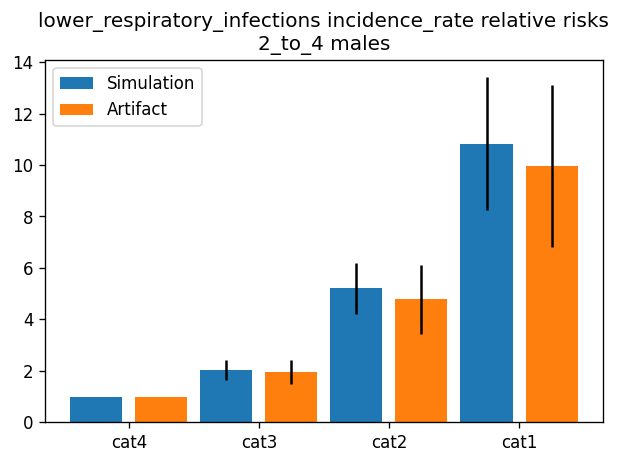

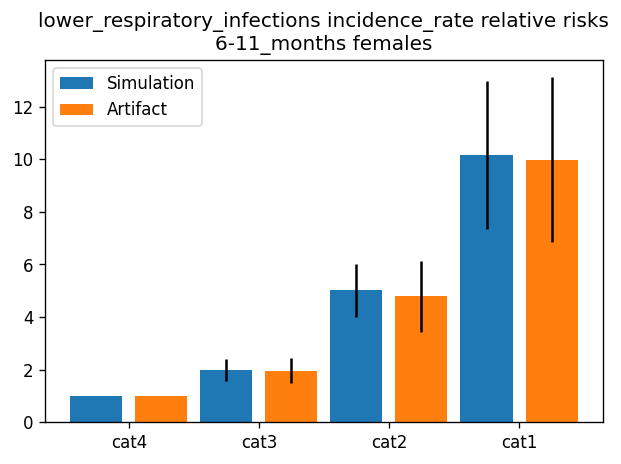

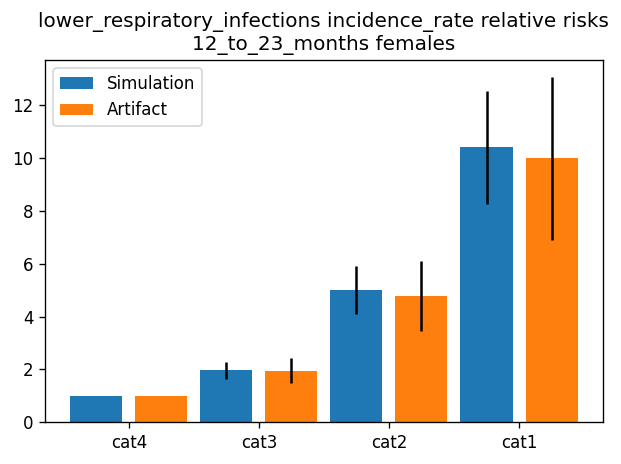

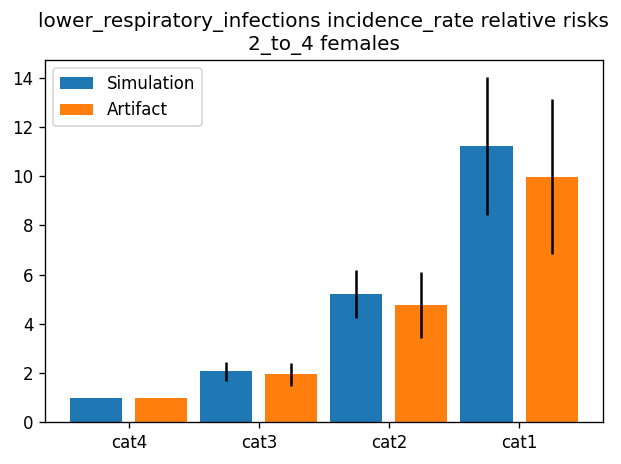

In [16]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'incidence_rate')

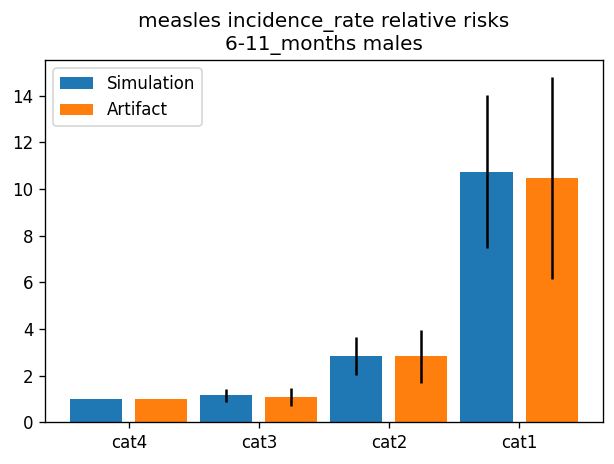

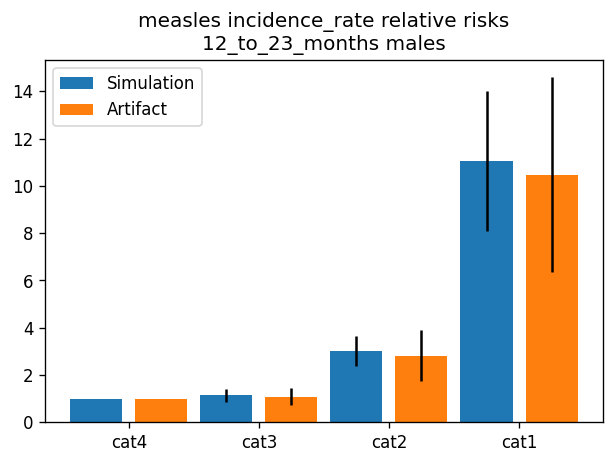

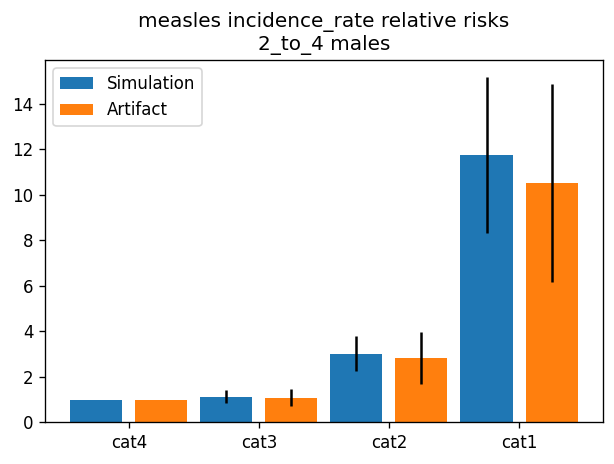

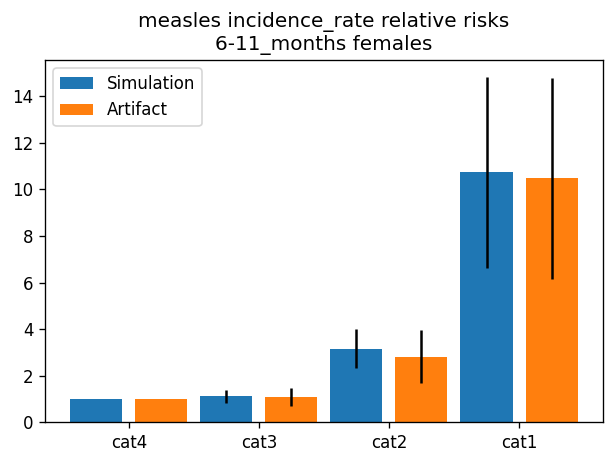

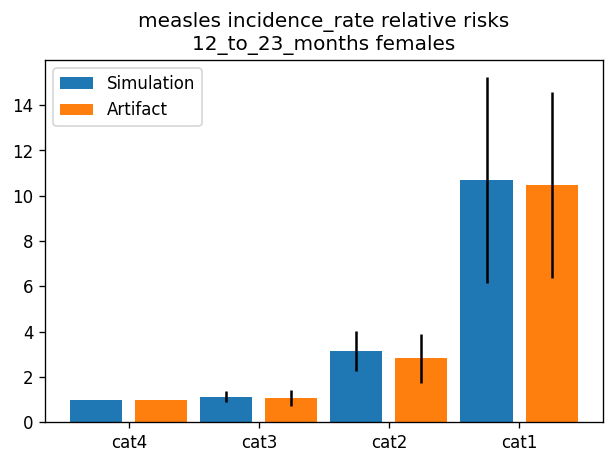

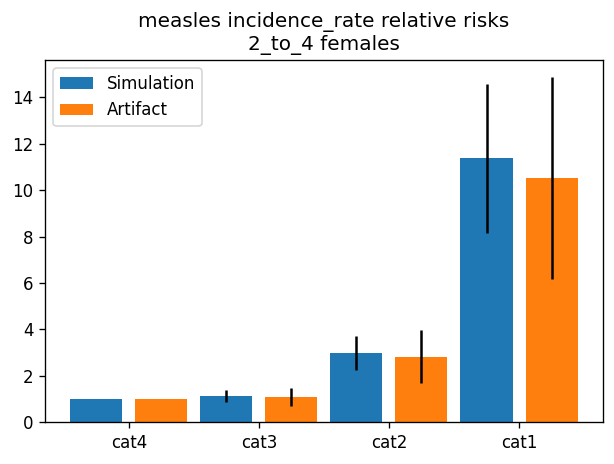

In [17]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'measles', 'incidence_rate')

In [18]:
# diarrheal incidence rrs
dt = pd.read_csv(output_dir + 'diarrhea_transition_count.csv')
dpt = pd.read_csv(output_dir + 'diarrhea_state_person_time.csv')

In [24]:
cols = ['age','sex']

a = ((dt.loc[(dt.measure=='susceptible_to_diarrheal_diseases_to_diarrheal_diseases_event_count')].groupby(['input_draw','wasting_state']+cols).sum()[['value']])
/ (dpt.loc[(dpt.cause=='susceptible_to_diarrheal_diseases')]
  .groupby(['input_draw','wasting_state']+cols).sum()[['value']])).reset_index()
ab = a.loc[a.wasting_state=='susceptible_to_child_wasting']
rrs = (a.set_index(['input_draw'] + cols + ['wasting_state'])
       / a.set_index(['input_draw'] + cols)[['value']])
rrs.groupby(['age','sex','wasting_state']).describe()

value                      \
                                                    count      mean       std   
age             sex    wasting_state                                            
1-5_months      female mild_child_wasting            44.0  0.999097  0.014783   
                       moderate_acute_malnutrition   44.0  0.999447  0.014790   
                       severe_acute_malnutrition     44.0  1.003530  0.022118   
                       susceptible_to_child_wasting  44.0  0.998491  0.014643   
                male   mild_child_wasting            44.0  1.001808  0.013017   
                       moderate_acute_malnutrition   44.0  0.997643  0.015720   
                       severe_acute_malnutrition     44.0  1.000594  0.017391   
                       susceptible_to_child_wasting  44.0  1.000378  0.011794   
12_to_23_months female mild_child_wasting            44.0  0.985014  0.036915   
                       moderate_acute_malnutrition   44.0  1.031576  0.042188   
                       severe_acute_malnutrition     44.0  1.031649  0.042402   
                       susceptible_to_child_wasting  44.0  0.956883  0.037527   
                male   mild_child_wasting            44.0  0.987470  0.041997   
                       moderate_acute_malnutrition   44.0  1.038514  0.046219   
                       severe_acute_malnutrition     44.0  1.028836  0.048418   
                       susceptible_to_child_wasting  44.0  0.951556  0.044298   
2_to_4          female mild_child_wasting            44.0  0.983374  0.045821   
                       moderate_acute_malnutrition   44.0  1.038917  0.050977   
                       severe_acute_malnutrition     44.0  1.039528  0.055714   
                       susceptible_to_child_wasting  44.0  0.946299  0.050647   
                male   mild_child_wasting            44.0  0.985493  0.047576   
                       moderate_acute_malnutrition   44.0  1.037658  0.052044   
                       severe_acute_malnutrition     44.0  1.041868  0.057372   
                       susceptible_to_child_wasting  44.0  0.943519  0.051341   
6-11_months     female mild_child_wasting            44.0  0.990820  0.027527   
                       moderate_acute_malnutrition   44.0  1.031213  0.029815   
                       severe_acute_malnutrition     44.0  0.998792  0.033084   
                       susceptible_to_child_wasting  44.0  0.981573  0.027248   
                male   mild_child_wasting            44.0  0.992488  0.023788   
                       moderate_acute_malnutrition   44.0  1.025791  0.027071   
                       severe_acute_malnutrition     44.0  1.006018  0.025088   
                       susceptible_to_child_wasting  44.0  0.977588  0.025465   
early_neonatal  female mild_child_wasting            44.0  1.007729  0.087094   
                       moderate_acute_malnutrition   44.0  1.007982  0.105880   
                       severe_acute_malnutrition     44.0  0.998330  0.119621   
                       susceptible_to_child_wasting  44.0  1.005328  0.084391   
                male   mild_child_wasting            44.0  0.999694  0.062748   
                       moderate_acute_malnutrition   44.0  1.009623  0.066450   
                       severe_acute_malnutrition     44.0  0.994896  0.080683   
                       susceptible_to_child_wasting  44.0  1.004889  0.061584   
late_neonatal   female mild_child_wasting            44.0  0.998724  0.033453   
                       moderate_acute_malnutrition   44.0  0.990481  0.039740   
                       severe_acute_malnutrition     44.0  1.015531  0.045887   
                       susceptible_to_child_wasting  44.0  0.998288  0.032553   
                male   mild_child_wasting            44.0  0.998975  0.031389   
                       moderate_acute_malnutrition   44.0  1.001403  0.030887   
                       severe_acute_malnutrition     44.0  0.992527  0.040032   
  

In [24]:
def calculate_csmr_rrs(strata_cols):
    d = deaths.reset_index()
    d = d.loc[(d.scenario=='baseline')
             &(d.cause.isin(['diarrheal_diseases',
                            'lower_respiratory_infections',
                            'measles']))
             #&(d.age.isin(['12_to_23_months','2_to_4']))
             ]
    d = d.groupby(strata_cols + ['input_draw','wasting_state','cause']).sum()[['value']]
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
              .loc[(state_pt.scenario=='baseline')]
              .groupby(strata_cols + ['input_draw','wasting_state']).sum())[['value']]
    d = (d / pt).reset_index()
    d_tmrel = d.loc[d.wasting_state.str.contains('susc')].set_index(strata_cols + ['input_draw','cause'])[['value']]
    d = d.set_index(strata_cols + ['input_draw','cause','wasting_state']) / d_tmrel
    d = d.groupby(strata_cols + ['cause','wasting_state']).describe()
    return d

In [25]:
calculate_csmr_rrs([])

value             \
                                                          count       mean   
cause                        wasting_state                                   
diarrheal_diseases           mild_child_wasting            11.0   1.567947   
                             moderate_acute_malnutrition   11.0   4.780952   
                             severe_acute_malnutrition     11.0  11.540338   
                             susceptible_to_child_wasting  11.0   1.000000   
lower_respiratory_infections mild_child_wasting            11.0   1.544949   
                             moderate_acute_malnutrition   11.0   3.161235   
                             severe_acute_malnutrition     11.0   6.306984   
                             susceptible_to_child_wasting  11.0   1.000000   
measles                      mild_child_wasting            11.0   0.988989   
                             moderate_acute_malnutrition   11.0   2.650506   
                             severe_acute_malnutrition     11.0   8.674793   
                             susceptible_to_child_wasting  11.0   1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.223178  1.277547   
                             moderate_acute_malnutrition   0.741098  3.577437   
                             severe_acute_malnutrition     2.419371  7.173958   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.210961  1.209825   
                             moderate_acute_malnutrition   0.404938  2.592010   
                             severe_acute_malnutrition     1.609550  3.321360   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.308695  0.314315   
                             moderate_acute_malnutrition   0.858291  1.431586   
                             severe_acute_malnutrition     3.432432  4.119840   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                     \
                                                                25%   
cause                        wasting_state                            
diarrheal_diseases           mild_child_wasting            1.410590   
                             moderate_acute_malnutrition   4.354344   
                             severe_acute_malnutrition     9.893860   
                             susceptible_to_child_wasting  1.000000   
lower_respiratory_infections mild_child_wasting            1.389720   
                             moderate_acute_malnutrition   2.826737   
                             severe_acute_malnutrition     5.267238   
                             susceptible_to_child_wasting  1.000000   
measles                      mild_child_wasting            0.790642   
                             moderate_acute_malnutrition   2.239786   
                             severe_acute_malnutrition     6.427675   
                             susceptible_to_child_wasting  1.000000   

                                                                      \
                                                                 50%   
cause                        wasting_state                             
diarrheal_diseases           mild_child_wasting             1.598335   
                             moderate_acute_malnutrition    4.925411   
                             severe_acute_malnutrition     11.572967   
                             susceptible_to_child_wasting   1.000000   
lower_respiratory_infections mild_child_wasting             1.614235   
                             

In [26]:
csmr_rrs = calculate_csmr_rrs(['age','sex'])
csmr_rrs.head()

value  \
                                                                            count   
age        sex    cause                        wasting_state                        
1-5_months female diarrheal_diseases           mild_child_wasting            11.0   
                                               moderate_acute_malnutrition   11.0   
                                               severe_acute_malnutrition     11.0   
                                               susceptible_to_child_wasting  11.0   
                  lower_respiratory_infections mild_child_wasting            11.0   

                                                                                       \
                                                                                 mean   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            1.054070   
                                               moderate_acute_malnutrition   1.037136   
                                               severe_acute_malnutrition     1.027185   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            1.162561   

                                                                                       \
                                                                                  std   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.283140   
                                               moderate_acute_malnutrition   0.625518   
                                               severe_acute_malnutrition     1.097235   
                                               susceptible_to_child_wasting  0.000000   
                  lower_respiratory_infections mild_child_wasting            0.489336   

                                                                                       \
                                                                                  min   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.521583   
                                               moderate_acute_malnutrition   0.229497   
                                               severe_acute_malnutrition     0.000000   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            0.463800   

                                                                                       \
                                                                                  25%   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.853488   
                                               moderate_acute_malnutrition   0.709579   
                                               severe_acute_malnutrition     0.000000   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            0.907105   

                                                                                       \
                                                                                  50%   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            1.165997   
                                               moderate_acute_malnutrition   0.776574   
                                               severe_acute_malnutrition     0.629504   
         

In [27]:
def plot_csmr_relative_risks(age, sex, cause, measure):
    width=0.4
    s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

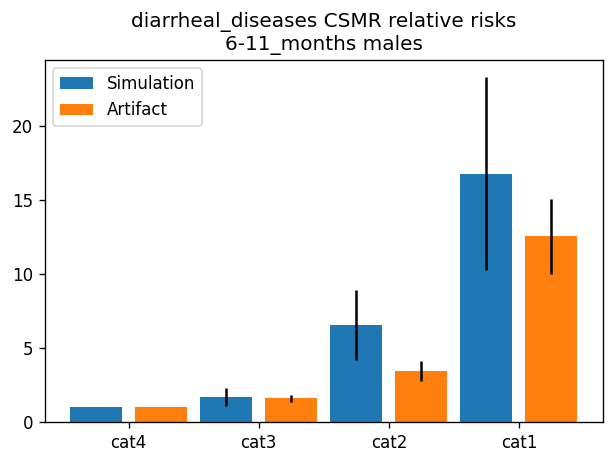

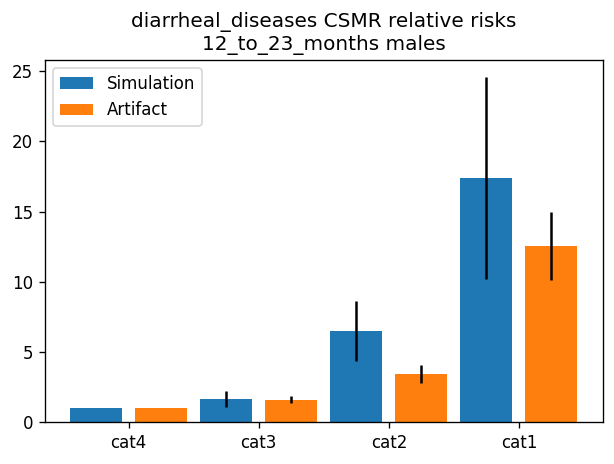

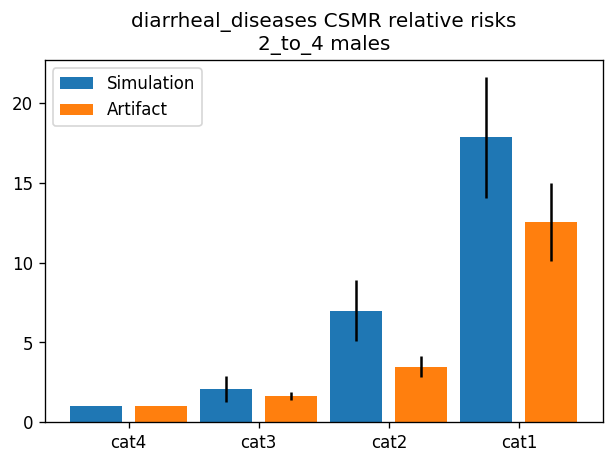

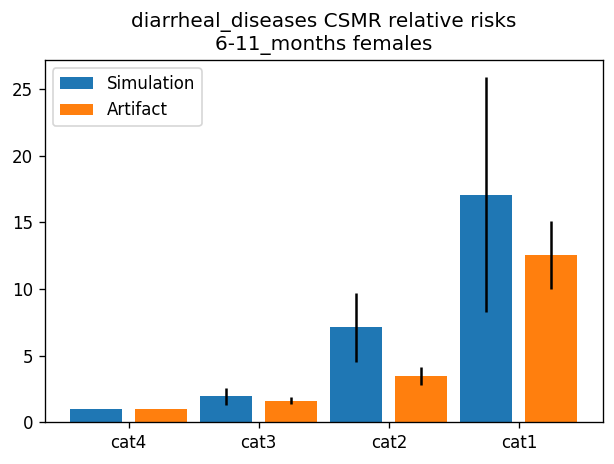

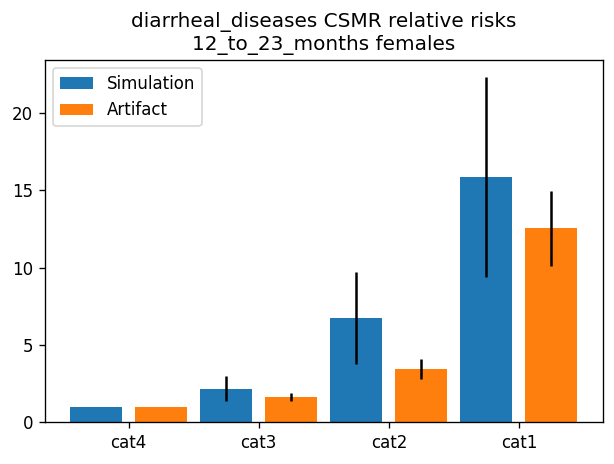

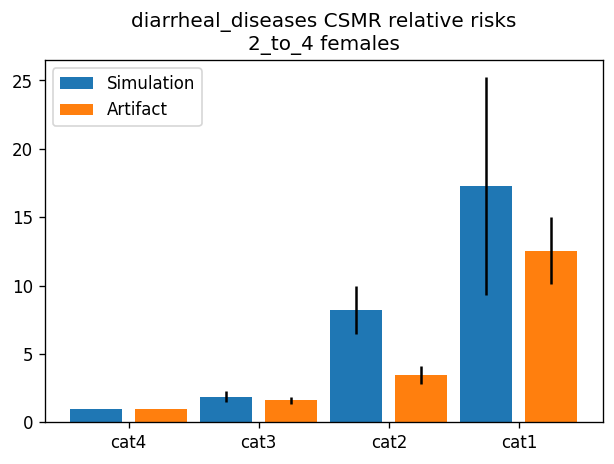

In [28]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'CSMR')

FloatingPointError: invalid value encountered in reduce

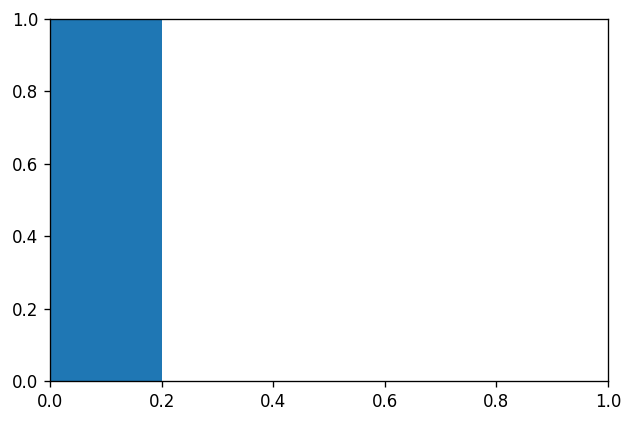

In [30]:
for sex in ['male','female']:
    for age in ['12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'CSMR')

# so now EMRs

In [31]:
d = deaths.reset_index()
d = d.loc[(d.scenario=='baseline')&(d.cause=='diarrheal_diseases')]
d = d.groupby(['input_draw','sex','age','wasting_state']).sum()[['value']]
pt = state_pt.loc[(state_pt.cause=='diarrheal_diseases')
                 &(state_pt.scenario=='baseline')]
pt = pt.groupby(['input_draw','sex','age','wasting_state']).sum()[['value']]
emr = d/pt
emr_tmrel = (emr.reset_index().loc[emr.reset_index().wasting_state=='susceptible_to_child_wasting']
             .set_index(['input_draw','sex','age'])[['value']])
diarrhea_emr_rr = emr / emr_tmrel
diarrhea_emr_rr = diarrhea_emr_rr.groupby(['sex','age','wasting_state']).describe()
diarrhea_emr_rr.head()

value                   \
                                                    count mean std min 25%   
sex    age             wasting_state                                         
female 1-5_months      mild_child_wasting             0.0  NaN NaN NaN NaN   
                       moderate_acute_malnutrition    0.0  NaN NaN NaN NaN   
                       severe_acute_malnutrition      0.0  NaN NaN NaN NaN   
                       susceptible_to_child_wasting   0.0  NaN NaN NaN NaN   
       12_to_23_months mild_child_wasting             0.0  NaN NaN NaN NaN   

                                                                 
                                                    50% 75% max  
sex    age             wasting_state                             
female 1-5_months      mild_child_wasting           NaN NaN NaN  
                       moderate_acute_malnutrition  NaN NaN NaN  
                       severe_acute_malnutrition    NaN NaN NaN  
                       susceptible_to_child_wasting NaN NaN NaN  
       12_to_23_months mild_child_wasting           NaN NaN NaN

In [32]:
def plot_emr_rrs(age, sex):
    width=0.4
    measure = 'EMR'
    cause = 'diarrheal_diseases'
    s = diarrhea_emr_rr.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             #&(s.cause==cause)
             ]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

FloatingPointError: invalid value encountered in reduce

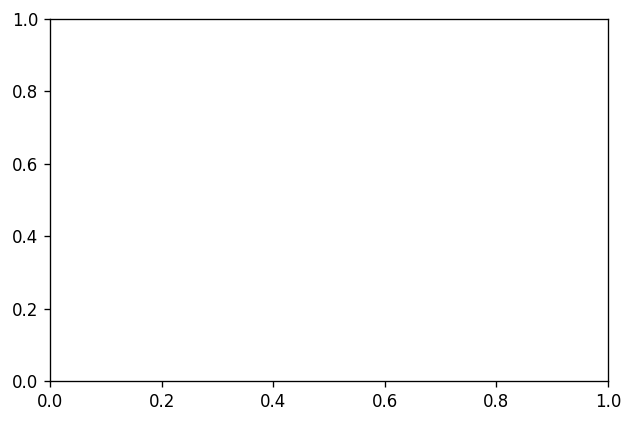

In [33]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
        plot_emr_rrs(age, sex)